In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load Breast Cancer dataset
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train_scaled, y_train)
dt_pred = dt.predict(X_test_scaled)
dt_accuracy = accuracy_score(y_test, dt_pred)
print("Decision Tree Results:")
print(f"Accuracy: {dt_accuracy:.4f}")
print(classification_report(y_test, dt_pred, target_names=cancer.target_names))

# Train and evaluate KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test, knn_pred)
print("\nK-Nearest Neighbors Results:")
print(f"Accuracy: {knn_accuracy:.4f}")
print(classification_report(y_test, knn_pred, target_names=cancer.target_names))

Decision Tree Results:
Accuracy: 0.9474
              precision    recall  f1-score   support

   malignant       0.93      0.93      0.93        43
      benign       0.96      0.96      0.96        71

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114


K-Nearest Neighbors Results:
Accuracy: 0.9474
              precision    recall  f1-score   support

   malignant       0.93      0.93      0.93        43
      benign       0.96      0.96      0.96        71

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



Decision Tree Accuracy: 0.9667


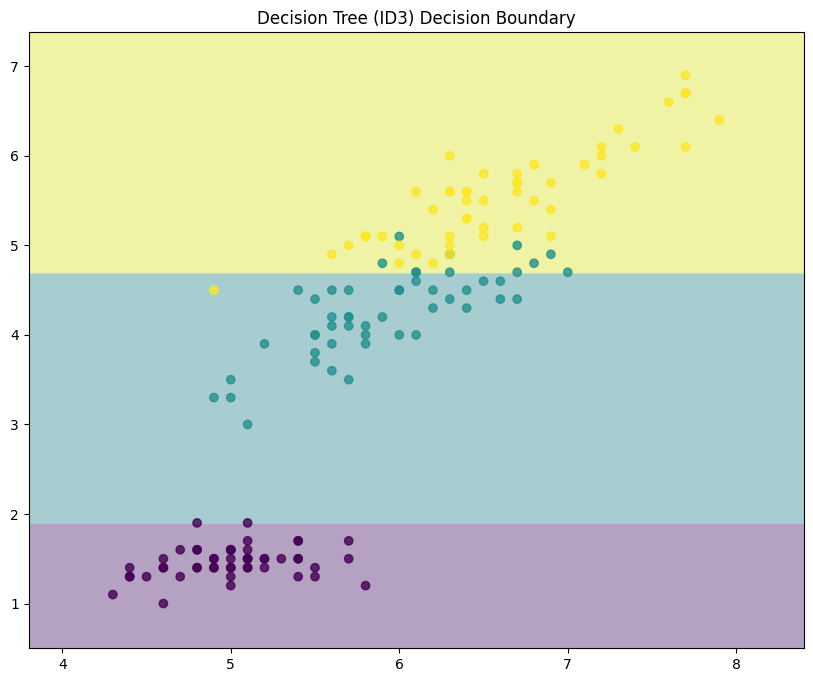

Decision Tree prediction for new sample: setosa


In [ ]:
#Decision tree using ID3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.datasets import load_iris, make_regression
from sklearn.preprocessing import StandardScaler

def plot_decision_boundary(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.title(title)
    plt.show()

from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTreeID3:
    def __init__(self, max_depth=100):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.n_features = X.shape[1]
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or n_labels == 1 or n_samples < 2):
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, n_features, replace=False)

        best_feat, best_thresh = self._best_split(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self._split(X_column, threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r
        return parent_entropy - child_entropy

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

# Load Iris dataset
iris = load_iris()
X, y = iris.data[:, [0, 2]], iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the decision tree
dt = DecisionTreeID3(max_depth=2)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.4f}")

# Plot decision boundary
plot_decision_boundary(X, y, dt, "Decision Tree (ID3) Decision Boundary")

# Classify a new sample
new_sample = np.array([[5.0, 1.5]])
prediction = dt.predict(new_sample)
print(f"Decision Tree prediction for new sample: {iris.target_names[prediction[0]]}")

k-NN Accuracy: 0.9667


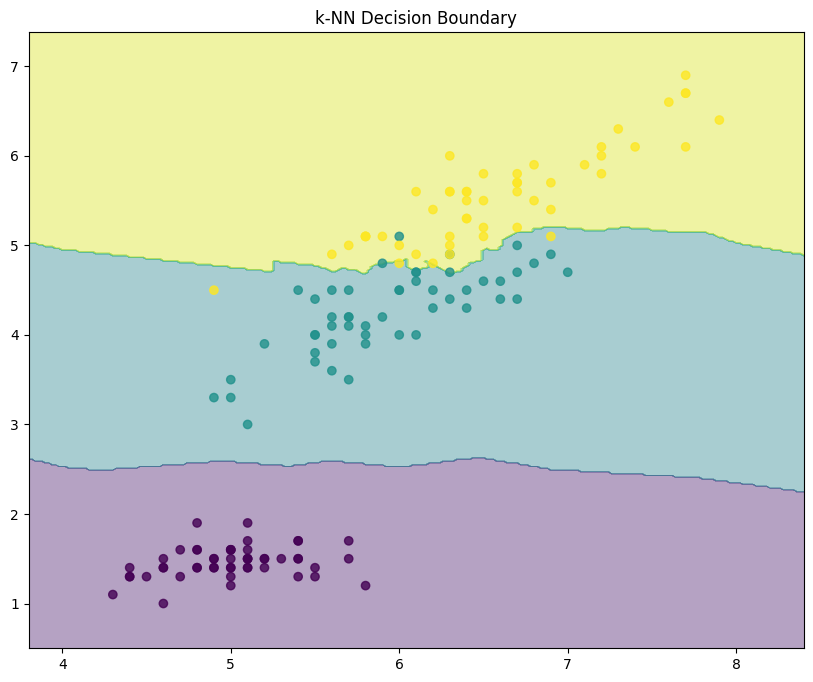


k-NN Predictions:
True: versicolor, Predicted: versicolor, Correct
True: setosa, Predicted: setosa, Correct
True: virginica, Predicted: virginica, Correct
True: versicolor, Predicted: versicolor, Correct
True: versicolor, Predicted: versicolor, Correct
True: setosa, Predicted: setosa, Correct
True: versicolor, Predicted: versicolor, Correct
True: virginica, Predicted: versicolor, Wrong
True: versicolor, Predicted: versicolor, Correct
True: versicolor, Predicted: versicolor, Correct
True: virginica, Predicted: virginica, Correct
True: setosa, Predicted: setosa, Correct
True: setosa, Predicted: setosa, Correct
True: setosa, Predicted: setosa, Correct
True: setosa, Predicted: setosa, Correct
True: versicolor, Predicted: versicolor, Correct
True: virginica, Predicted: virginica, Correct
True: versicolor, Predicted: versicolor, Correct
True: versicolor, Predicted: versicolor, Correct
True: virginica, Predicted: virginica, Correct
True: setosa, Predicted: setosa, Correct
True: virginica, Pr

In [ ]:
#KNN implementation

import numpy as np
from collections import Counter
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        distances = [np.sqrt(np.sum((x - x_train) ** 2)) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

def plot_decision_boundary(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.title(title)
    plt.show()

# Load the Iris dataset
iris = load_iris()
X, y = iris.data[:, [0, 2]], iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate k-NN
knn = KNN(k=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"k-NN Accuracy: {accuracy:.4f}")

# Plot decision boundary
plot_decision_boundary(X, y, knn, "k-NN Decision Boundary")

# Print correct and wrong predictions
print("\nk-NN Predictions:")
for true, pred in zip(y_test, y_pred):
    print(f"True: {iris.target_names[true]}, Predicted: {iris.target_names[pred]}, {'Correct' if true == pred else 'Wrong'}")

# Classify a new sample
new_sample = np.array([[5.0, 1.5]])
prediction = knn.predict(new_sample)
print(f"\nk-NN prediction for new sample: {iris.target_names[prediction[0]]}")

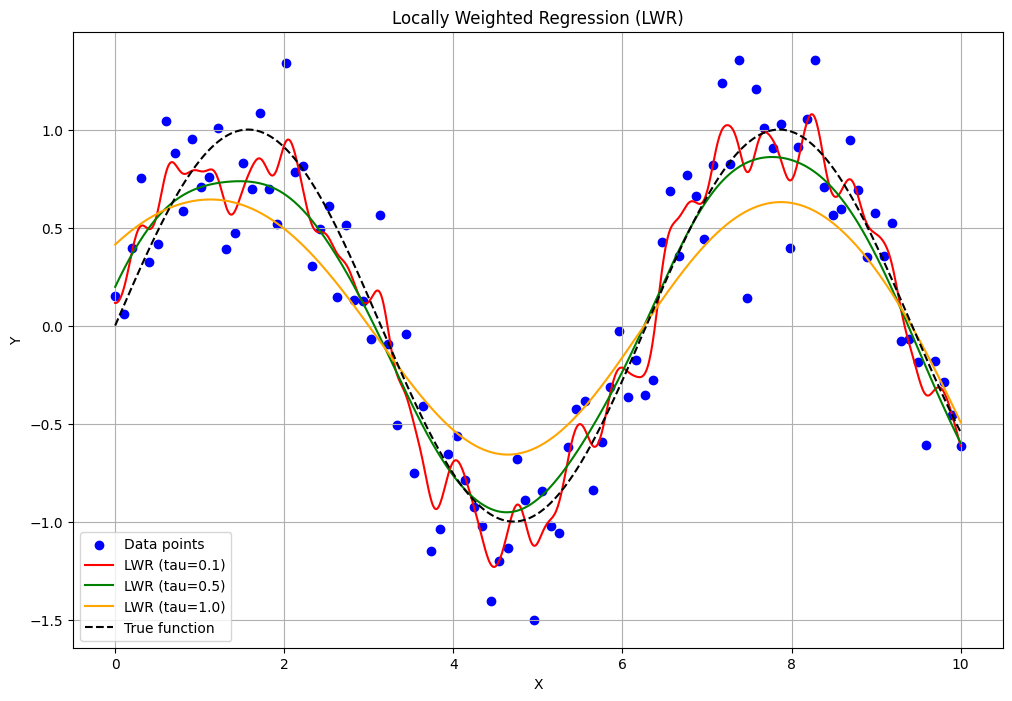

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lstsq

def lwr(x, y, x_pred, tau=0.5):
    """
    Locally Weighted Regression
    x: input features
    y: target values
    x_pred: prediction points
    tau: bandwidth parameter
    """
    y_pred = []
    for xi in x_pred:
        weights = np.exp(-((x - xi) ** 2) / (2 * tau ** 2))
        W = np.diag(weights)
        X = np.column_stack([np.ones_like(x), x])
        theta = lstsq(np.sqrt(W).dot(X), np.sqrt(W).dot(y))[0]
        y_pred.append(np.dot([1, xi], theta))
    return np.array(y_pred)

# Generate synthetic data
np.random.seed(42)
x = np.linspace(0, 10, 100)
y = np.sin(x) + 0.3 * np.random.randn(100)

# Prediction points
x_pred = np.linspace(0, 10, 1000)

# Perform LWR with different bandwidth values
y_pred_01 = lwr(x, y, x_pred, tau=0.1)
y_pred_05 = lwr(x, y, x_pred, tau=0.5)
y_pred_10 = lwr(x, y, x_pred, tau=1.0)

# Plot results
plt.figure(figsize=(12, 8))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x_pred, y_pred_01, color='red', label='LWR (tau=0.1)')
plt.plot(x_pred, y_pred_05, color='green', label='LWR (tau=0.5)')
plt.plot(x_pred, y_pred_10, color='orange', label='LWR (tau=1.0)')
plt.plot(x_pred, np.sin(x_pred), color='black', linestyle='--', label='True function')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Locally Weighted Regression (LWR)')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-4-01a5164896d4>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = np.hstack([1, X_test[i]]) @ theta


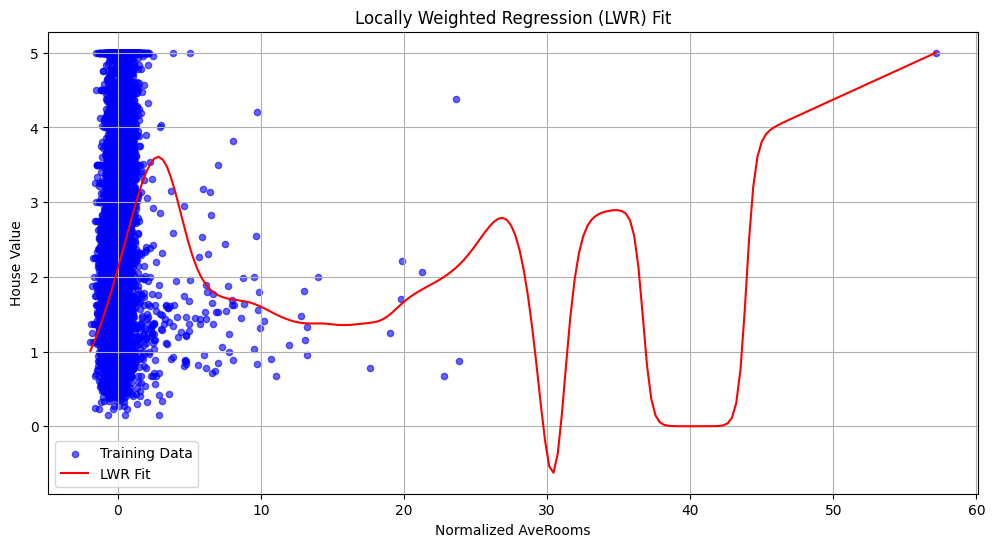

KeyboardInterrupt: 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

california = fetch_california_housing()
X = california.data
y = california.target
feature_names = california.feature_names
feature_name = 'AveRooms'
feature_idx = feature_names.index(feature_name)

X = X[:, feature_idx].reshape(-1, 1)
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def locally_weighted_regression(X_train, y_train, X_test, tau, lambda_param=1e-6):
    m = X_train.shape[0]
    n = X_test.shape[0]
    y_pred = np.zeros(n)

    for i in range(n):
        weights = np.exp(-np.sum((X_train - X_test[i]) ** 2, axis=1) / (2 * tau ** 2 + 1e-8))
        W = np.diag(weights)
        X_weighted = np.hstack([np.ones((m, 1)), X_train])
        XWX = X_weighted.T @ W @ X_weighted
        XWX_ridge = XWX + lambda_param * np.eye(XWX.shape[0])  # Add ridge term
        theta = np.linalg.pinv(XWX_ridge) @ X_weighted.T @ W @ y_train
        y_pred[i] = np.hstack([1, X_test[i]]) @ theta

    return y_pred

tau = 2.0  # Increased bandwidth for smoother fit
lambda_param = 1e-6  # Ridge parameter

X_plot = np.linspace(X_train_scaled.min(), X_train_scaled.max(), 200).reshape(-1, 1)
predictions = locally_weighted_regression(X_train_scaled, y_train, X_plot, tau, lambda_param)

plt.figure(figsize=(12, 6))
plt.scatter(X_train_scaled, y_train, color='blue', label='Training Data', alpha=0.6, s=20)
plt.plot(X_plot, predictions, color='red', label='LWR Fit')
plt.xlabel(f'Normalized {feature_name}')
plt.ylabel('House Value')
plt.title('Locally Weighted Regression (LWR) Fit')
plt.legend()
plt.grid(True)
plt.show()

y_pred_test = locally_weighted_regression(X_train_scaled, y_train, X_test_scaled, tau, lambda_param)
mse = np.mean((y_test - y_pred_test) ** 2)
print(f"Mean Squared Error: {mse}")

In [ ]:
#ANN implementation

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data = datasets.FashionMNIST(root='./', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./', train=False, download=True, transform=transforms.ToTensor())

BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, drop_last=True)

class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.model(x)

input_dim = 28 * 28
hidden_dim = 64
output_dim = len(train_data.classes)

model = ANNModel(input_dim, hidden_dim, output_dim).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

def train_model(model, dataloader, loss_fn, optimizer, device):
    model.train()
    model.to(device)
    epochs = 10
    for epoch in range(epochs):
        train_acc, train_loss = 0, 0
        for idx, (x_train, y_train) in enumerate(dataloader):
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_logits = model(x_train)
            y_preds = y_logits.argmax(dim=1).squeeze()
            loss = loss_fn(y_logits, y_train)
            train_loss += loss.item()
            acc = (y_preds == y_train).sum().item()
            train_acc += acc

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_acc /= len(dataloader.dataset)
        train_loss /= len(dataloader)
        print(f"Epoch train loss : {train_loss:.3f} | Epoch train acc : {train_acc:.2f}%")

def test_model(model, dataloader, loss_fn, device):
    model.eval()
    model.to(device)
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for x_test, y_test in dataloader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            test_logits = model(x_test)
            test_preds = test_logits.argmax(dim=1).squeeze()
            loss = loss_fn(test_logits, y_test)
            test_loss += loss.item()
            acc = (test_preds == y_test).sum().item()
            test_acc += acc

    test_acc /= len(dataloader.dataset)
    test_loss /= len(dataloader)
    print(f"Test loss : {test_loss:.3f} | Test accuracy : {test_acc:.2f}%")

train_model(model, train_dataloader, loss_fn, optimizer, device)
test_model(model, test_dataloader, loss_fn, device)

Epoch train loss : 0.673 | Epoch train acc : 0.75%
Epoch train loss : 0.431 | Epoch train acc : 0.84%
Epoch train loss : 0.387 | Epoch train acc : 0.86%
Epoch train loss : 0.360 | Epoch train acc : 0.87%
Epoch train loss : 0.340 | Epoch train acc : 0.87%
Epoch train loss : 0.322 | Epoch train acc : 0.88%
Epoch train loss : 0.310 | Epoch train acc : 0.88%
Epoch train loss : 0.300 | Epoch train acc : 0.89%
Epoch train loss : 0.293 | Epoch train acc : 0.89%
Epoch train loss : 0.283 | Epoch train acc : 0.89%
Test loss : 0.372 | Test accuracy : 0.86%


In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score

iris = fetch_openml('iris', version=1)
X = iris.data
y = iris.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


def infer_labels(clusters, true_labels):
    inferred_labels = {}
    for i in np.unique(clusters):
        mask = (clusters == i)
        sub_labels = true_labels[mask]
        if len(sub_labels) > 0:
            inferred_labels[i] = sub_labels.value_counts().idxmax()
        else:
            inferred_labels[i] = None
    return inferred_labels

def map_labels(clusters, inferred_labels):
    mapped_labels = np.array([inferred_labels[cluster] for cluster in clusters])
    return mapped_labels

kmeans_accs = []
kmeans_sil_scores = []
kmeans_ari_scores = []

for _ in range(10):
    kmeans = KMeans(n_clusters=3, n_init=1, random_state=0)
    clusters_kmeans = kmeans.fit_predict(X_scaled)
    inferred_labels_kmeans = infer_labels(clusters_kmeans, y)
    mapped_labels_kmeans = map_labels(clusters_kmeans, inferred_labels_kmeans)

    accuracy_kmeans = accuracy_score(y, mapped_labels_kmeans)
    silhouette_kmeans = silhouette_score(X_scaled, clusters_kmeans)
    ari_kmeans = adjusted_rand_score(y, clusters_kmeans)

    kmeans_accs.append(accuracy_kmeans)
    kmeans_sil_scores.append(silhouette_kmeans)
    kmeans_ari_scores.append(ari_kmeans)

average_accuracy_kmeans = np.mean(kmeans_accs)
average_silhouette_kmeans = np.mean(kmeans_sil_scores)
average_ari_kmeans = np.mean(kmeans_ari_scores)

gmm = GaussianMixture(n_components=3, random_state=0)
clusters_gmm = gmm.fit_predict(X_scaled)
inferred_labels_gmm = infer_labels(clusters_gmm, y)
mapped_labels_gmm = map_labels(clusters_gmm, inferred_labels_gmm)

accuracy_gmm = accuracy_score(y, mapped_labels_gmm)
silhouette_gmm = silhouette_score(X_scaled, clusters_gmm)
ari_gmm = adjusted_rand_score(y, clusters_gmm)

print(f'Average Accuracy for k-Means: {average_accuracy_kmeans:.2f}')
print(f'Average Silhouette Score for k-Means: {average_silhouette_kmeans:.2f}')
print(f'Accuracy for GMM: {accuracy_gmm:.2f}')
print(f'Silhouette Score for GMM: {silhouette_gmm:.2f}')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Average Accuracy for k-Means: 0.85
Average Silhouette Score for k-Means: 0.46
Accuracy for GMM: 0.97
Silhouette Score for GMM: 0.37
